In [46]:
from pathlib import Path
from models import utils as mutils
from sde_lib import VESDE
from sampling import (ReverseDiffusionPredictor,
                      LangevinCorrector,
                      get_pc_fouriercs_fast)
from models import ncsnpp
import time
from utils import fft2, ifft2, get_mask, get_data_scaler, get_data_inverse_scaler, restore_checkpoint
import torch
import torch.nn as nn
import numpy as np
from models.ema import ExponentialMovingAverage
import matplotlib.pyplot as plt
import importlib
import argparse
from PIL import Image

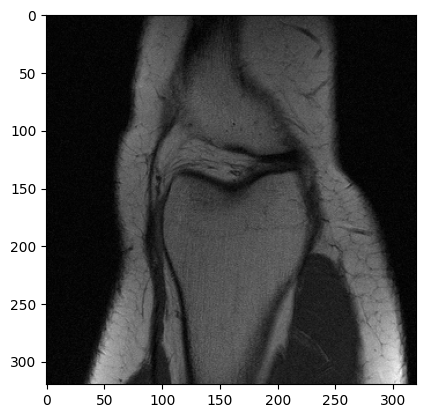

In [69]:
filename = f'./samples/real/retrospective/001.npy'
mask_filename = f'./samples/real/prospective/001_mask.npy'

configs = importlib.import_module(f"configs.ve.fastmri_knee_320_ncsnpp_continuous")
config = configs.get_config()
img_size = config.data.image_size
batch_size = 1

# Read data
img = torch.from_numpy(np.load(filename))

#display image
plt.imshow(img,cmap="gray")

In [70]:
img.shape

torch.Size([320, 320])

In [81]:
import numpy as np

def simulate_motion_artifact(image_data, rotation_range=(-2*np.pi, 2*np.pi), translation_range=(-10, 10), k0=10):
    """
    Simulate random translation and rotation motion artifact on MRI magnitude image.
    
    Parameters:
        image_data (numpy.ndarray): MRI magnitude image data for a single slice.
        rotation_range (tuple): Range for random rotation angle in radians. Default is (-2*np.pi, 2*np.pi).
        translation_range (tuple): Range for random translation in cm. Default is (-1, 1).
        k0 (float): Delay time of phase error due to centric k-space filling. Default is 10.
    
    Returns:
        numpy.ndarray: Simulated MRI magnitude image data with motion artifact.
    """
    artifact_data = np.zeros_like(image_data)
    num_rows, num_cols = image_data.shape
    
    rotation_angle = np.random.uniform(rotation_range[0], rotation_range[1])
    translation_x = np.random.uniform(translation_range[0], translation_range[1])
    translation_y = np.random.uniform(translation_range[0], translation_range[1])
    print(rotation_angle)
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            if np.abs(row_idx - num_rows / 2) > 0.5 or np.abs(col_idx - num_cols / 2) > 0.5:
                motion_x = translation_y * (col_idx - num_cols / 2) + translation_x * (row_idx - num_rows / 2)
                motion_y = - translation_x * (col_idx - num_cols / 2) + translation_y * (row_idx - num_rows / 2)
                phase_error_delay = k0 * (np.abs(motion_x) + np.abs(motion_y))
                    
                artifact_data[row_idx, col_idx] = image_data[row_idx, col_idx]
    
    return artifact_data


In [82]:

# Load the MRI magnitude image data for a single slice from .npy file
magnitude_image_data_slice = img#np.load("path_to_your_magnitude_image_slice.npy")

# Simulate motion artifact on the magnitude image slice
motion_artifact_magnitude_data_slice = simulate_motion_artifact(magnitude_image_data_slice)

# Save or further process motion artifact magnitude data slice

-3.311322160681797


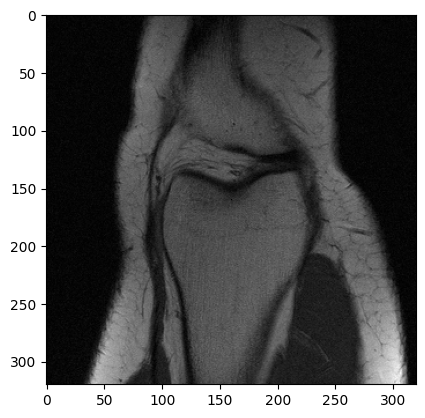

In [83]:
plt.imshow(motion_artifact_magnitude_data_slice,cmap="gray")

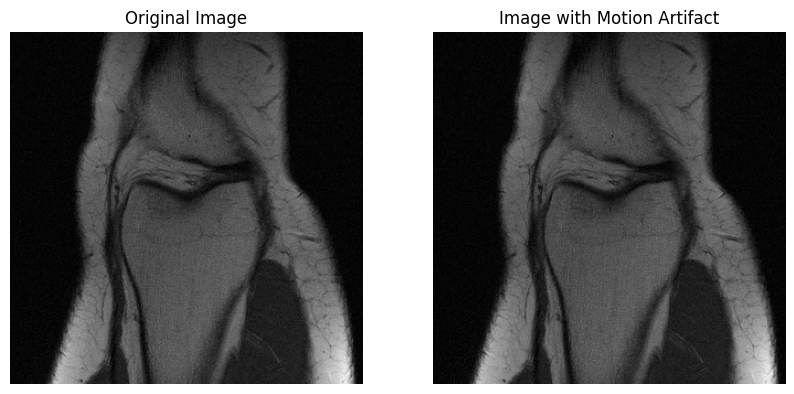

In [85]:
# Display original and motion artifact images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(motion_artifact_magnitude_data_slice, cmap='gray')
plt.title('Image with Motion Artifact')
plt.axis('off')

plt.show()

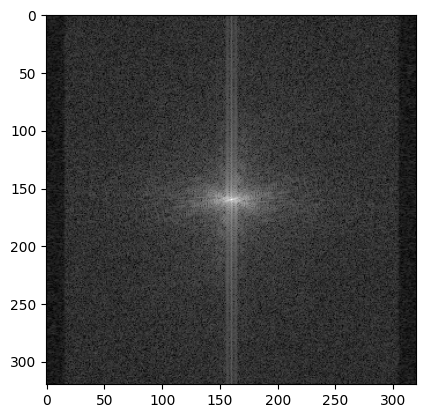

In [321]:
kspace = fft2(img)
plt.imshow(np.log(1 + np.abs(kspace)),cmap="gray")

In [87]:
img

tensor([[0.0185, 0.0348, 0.0090,  ..., 0.0469, 0.0049, 0.0067],
        [0.0420, 0.0376, 0.0075,  ..., 0.0196, 0.0083, 0.0110],
        [0.0172, 0.0237, 0.0170,  ..., 0.0332, 0.0356, 0.0113],
        ...,
        [0.0044, 0.0420, 0.0369,  ..., 0.0147, 0.0130, 0.0508],
        [0.0315, 0.0210, 0.0178,  ..., 0.0058, 0.0060, 0.0047],
        [0.0208, 0.0249, 0.0352,  ..., 0.0197, 0.0162, 0.0350]])

In [88]:
motion_artifact_magnitude_data_slice

array([[0.01847701, 0.03481908, 0.00897818, ..., 0.04692052, 0.00492761,
        0.00665036],
       [0.04203202, 0.03762624, 0.00754355, ..., 0.0195806 , 0.00834851,
        0.01097813],
       [0.01719471, 0.02369143, 0.01696265, ..., 0.03315864, 0.03562483,
        0.01131378],
       ...,
       [0.00443825, 0.04200095, 0.0368558 , ..., 0.01473782, 0.01296156,
        0.0507619 ],
       [0.03146714, 0.02099203, 0.01780173, ..., 0.00578096, 0.00598925,
        0.00467711],
       [0.02079699, 0.02489219, 0.03517655, ..., 0.01974767, 0.01622533,
        0.03496852]], dtype=float32)

(-0.5, 319.5, 319.5, -0.5)

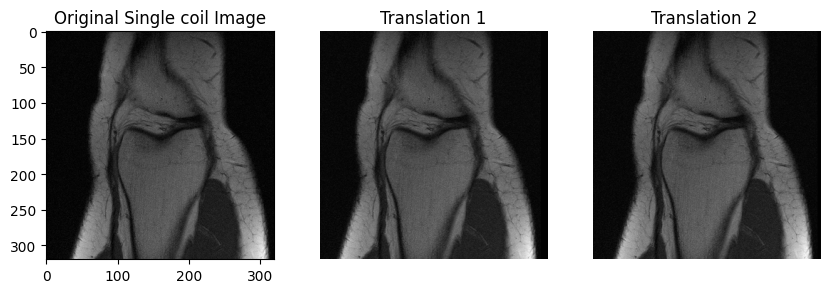

In [265]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

def simulate_motion_artifact(image, k0=np.pi/10):
    # Generate random values for deltaky, deltakx, and alphaky
    deltaky = np.random.uniform(-20, 10)  # Randomly sampled from [-1cm, 1cm]
    deltakx = np.random.uniform(0,0)  # Randomly sampled from [-0.5cm, 0.5cm]
    deltakx *= 0.01  # Convert from cm to magnitude image coordinates
    # deltaky *= 0.01
    # alphaky = np.random.uniform(-20, 20)  # Random sampled from [-2, 2] degrees

    # Convert rotation angle from degrees to radians
    #alphaky *= np.pi / 180

    # Apply the transformation
    #rotated_image = scipy.ndimage.rotate(image, alphaky, reshape=False)
    translation_matrix = np.array([[1, 0, deltakx], 
                                   [0, 1, deltaky], 
                                   [0, 0, 1]])
    transformed_image = scipy.ndimage.affine_transform(image, translation_matrix)

    return transformed_image

# Example usage:
# Load your magnitude image here
image = img            #load_magnitude_image("your_image_path.jpg")

#Simulate motion artifact on the magnitude image
simulated_image1 = simulate_motion_artifact(image)
simulated_image2 = simulate_motion_artifact(image)

#Display the original and simulated images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
#plt.axis("off")

plt.imshow(image, cmap='gray')
plt.title('Original Single coil Image')
plt.subplot(1, 3, 2)
plt.imshow(simulated_image1, cmap='gray')
plt.title('Translation 1')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(simulated_image2, cmap='gray')
plt.title('Translation 2 ')
plt.axis("off")
#plt.show()


In [185]:
# fft2(simulated_image)

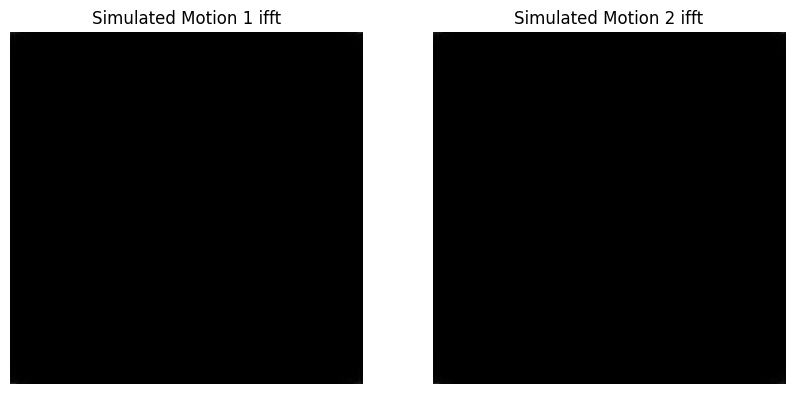

In [323]:
# Convert numpy arrays to PyTorch tensors
simulated_image1_tensor = torch.tensor(simulated_image1)
simulated_image2_tensor = torch.tensor(simulated_image2)

# Take the inverse Fourier transform (ifft)
simulated_image1_ifft = ifft2(simulated_image1_tensor)
simulated_image2_ifft = ifft2(simulated_image2_tensor)

# Convert tensors back to numpy arrays for visualization
simulated_image1_ifft_np = simulated_image1_ifft.numpy()
simulated_image2_ifft_np = simulated_image2_ifft.numpy()

# Display the ifft images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.log(1 + np.abs(simulated_image1_ifft_np)), cmap='gray')
plt.title('Simulated Motion 1 ifft')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(np.log(1 + np.abs(simulated_image2_ifft_np)), cmap='gray')
plt.title('Simulated Motion 2 ifft')
plt.axis("off")
plt.show()

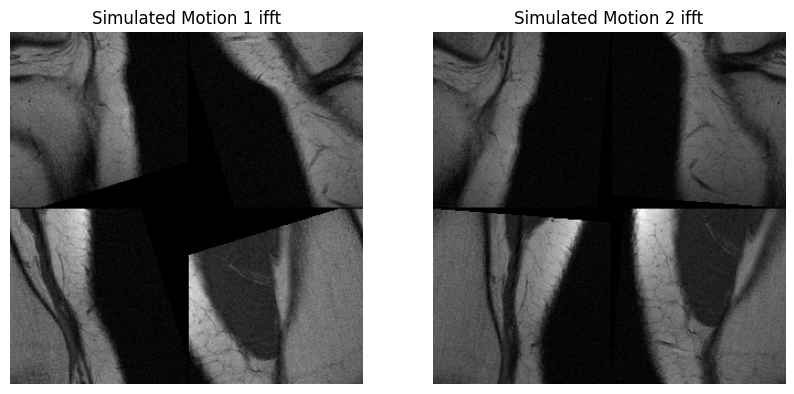

In [240]:
# Take the inverse Fourier transform (ifft)
simulated_imag1 = ifft2(simulated_image1_ifft)
simulated_imag2 = ifft2(simulated_image2_ifft)

# Convert tensors back to numpy arrays for visualization
simulated_image1_ifft_np = simulated_image1_ifft.numpy()
simulated_image2_ifft_np = simulated_image2_ifft.numpy()

# Display the ifft images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(simulated_imag1), cmap='gray')
plt.title('Simulated Motion 1 ifft')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(np.abs(simulated_imag2), cmap='gray')
plt.title('Simulated Motion 2 ifft')
plt.axis("off")
plt.show()

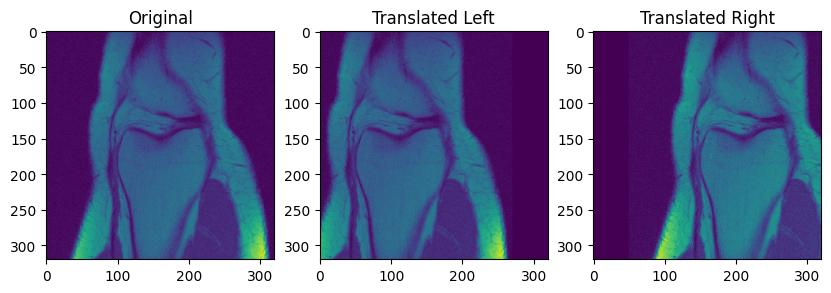

In [269]:
from scipy import ndimage

# Define the translation distances (in pixels)
# Define the translation distances (in pixels)
shift_left = (0, -50)  # Move left by 50 pixels
shift_right = (0, 50)  # Move right by 50 pixels
image=img
# Translate the image left
translated_left = ndimage.shift(image, shift_left, cval=0)

# Translate the image right
translated_right = ndimage.shift(image, shift_right, cval=0)

# Display the original and translated images
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(translated_left)
plt.title('Translated Left')

plt.subplot(1, 3, 3)
plt.imshow(translated_right)
plt.title('Translated Right')

plt.show()

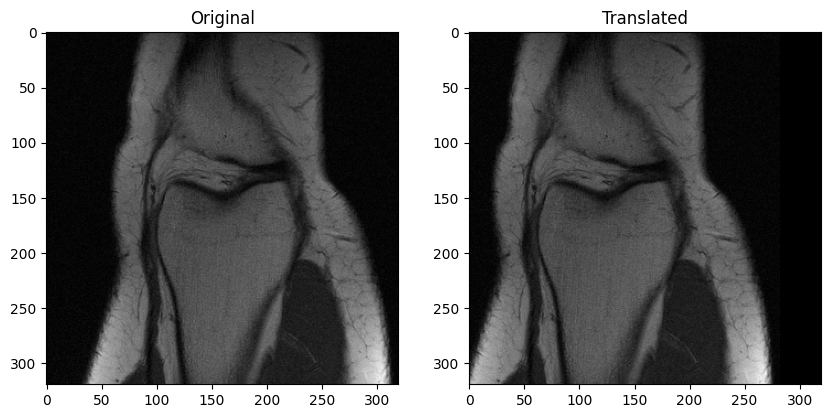

In [320]:
# Define the range for random translation
min_translation, max_translation = -10, 38

# Generate random translation values
#deltakx = np.random.randint(min_translation, max_translation)  #uniform(min_translation, max_translation)
deltaky = 38#np.random.randint(min_translation, max_translation) #uniform(min_translation, max_translation)

# Define the affine transformation matrix for translation
translation_matrix = np.array([[1, 0, 0],
                                [0, 1, deltaky],
                                [0, 0, 1]])

# Apply the affine transformation to the image
transformed_image = ndimage.affine_transform(image, translation_matrix)

# Display the original and translated images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image,cmap="gray")
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image,cmap="gray")
plt.title('Translated')

plt.show()